In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/prepared_train.csv')
df_base = pd.read_csv('./data/train.csv')

In [3]:
home_own = 'Home Ownership' # домовладение
ann_income = 'Annual Income' # годовой доход
years_on_job = 'Years in current job' # количество лет на текущем месте работы
tax_liens = 'Tax Liens' # налоговые льготы
numb_accounts = 'Number of Open Accounts' # количество открытых счетов
years_cred_hist = 'Years of Credit History' # количество лет кредитной истории
max_credit = 'Maximum Open Credit' # наибольший открытый кредит
cred_problems = 'Number of Credit Problems' # количество проблем с кредитом
months_last_delinq = 'Months since last delinquent' # количество месяцев с последней просрочки платежа
bancrupcies = 'Bankruptcies' # банкротства
purpose = 'Purpose' # цель кредита
term = 'Term' # срок кредита
term_bin = 'Term' # срок кредита бинарный тип
cur_loan_amount = 'Current Loan Amount' # текущая сумма кредита
cur_cred_bal = 'Current Credit Balance' # текущий кредитный баланс
month_debt = 'Monthly Debt' # ежемесячный долг
cred_score = 'Credit Score' # ???
cred_default = 'Credit Default' # факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term,Id
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,...,0,0,0,0,0,0,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,...,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,...,0,0,0,0,0,0,0,0,1,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,...,0,0,0,0,0,0,0,0,1,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,...,0,0,0,0,0,0,0,0,1,4


In [5]:
TARGET_NAME = cred_default
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [6]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [7]:
def plot_corr(features):
    corr_with_target = df[features + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with target variable')
    plt.show()

**Корреляция с базовыми признаками**

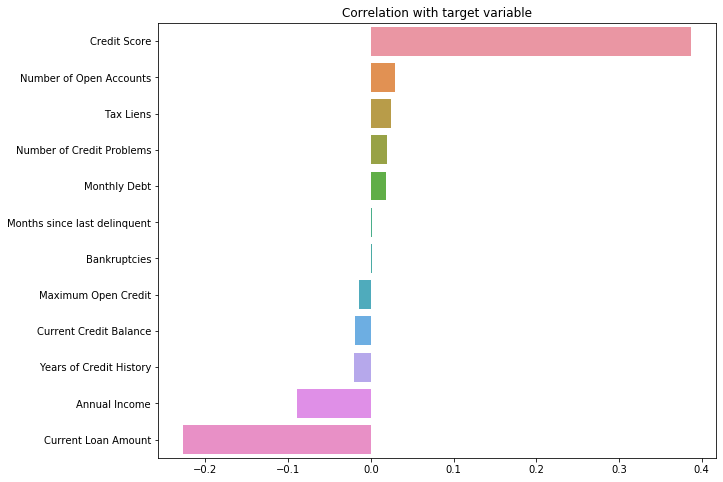

In [8]:
plot_corr(BASE_FEATURE_NAMES)

**Корреляция с новыми признаками**

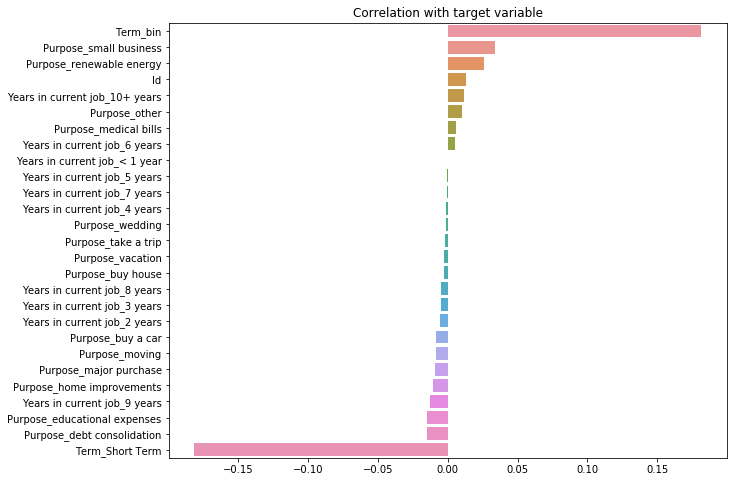

In [9]:
plot_corr(NEW_FEATURE_NAMES)

### Оценка признаков

In [10]:
def plot_count(colname):
    plt.figure(figsize=(10, 8))
    sns.countplot(x=colname, hue=TARGET_NAME, data=df)
    plt.legend(title='Target', loc='upper right')
    plt.show()

**Оценка признака Term**

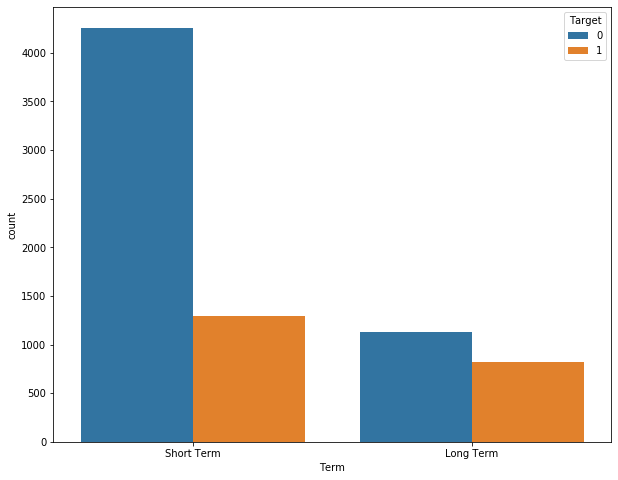

In [11]:
plot_count(term_bin)

**Оценка признака Current Loan Amount**

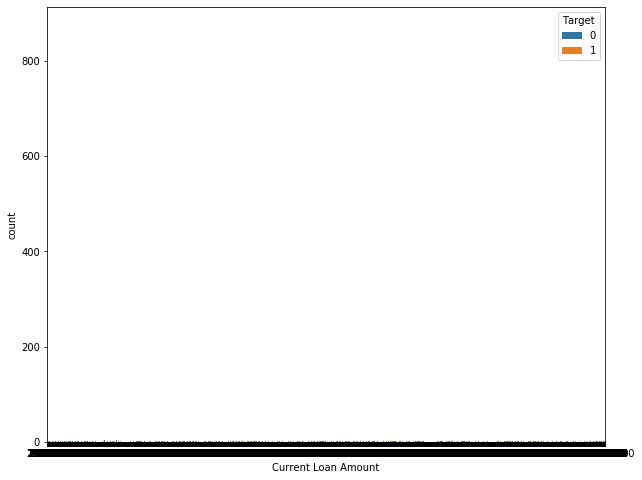

In [12]:
plot_count(cur_loan_amount)